In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve


def plot(image):
    plt.figure()
    plt.imshow(image.reshape((32, 32))
               if image.shape[0] != 32 else image, cmap="gray")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="none", cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # return fig


# Get data

In [2]:
import keras.datasets.cifar10 as cifar10

(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


# Randomize train data and sort test data

In [3]:
idx = rnd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]


# Convert images to grayscale

In [4]:
from skimage import color

XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])


# Convert images to vectors

In [5]:
XtrainG = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestG = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

print(XtrainG.shape, ytrain.shape)
print(XtestG.shape, ytest.shape)


(50000, 1024) (50000,)
(10000, 1024) (10000,)


# Normalization

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(XtrainG)
XtrainGS = ss.transform(XtrainG)
XtestGS = ss.transform(XtestG)


# Binarize for ship (index 8)

In [7]:
ytrainB = (ytrain == 8) * 1
ytestB = (ytest == 8) * 1


#### Change names

In [8]:
X1 = XtrainG
X1s = XtrainGS
y1 = ytrain
y1b = ytrainB
X2 = XtestG
X2s = XtestGS
y2 = ytest
y2b = ytestB

#! Takes a lot of time to train specially on model fine tuning. Needs to be optimized somehow


# Binary classification

## SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier


### Not normalized data

Score: 0.8997
Number of errors: 1003
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.00      0.00      0.00      1000

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



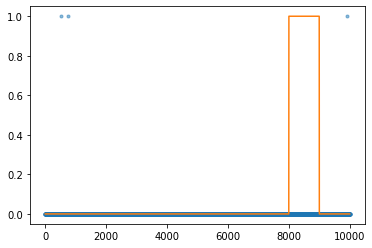

Prediction
[[8997    3]
 [1000    0]]


In [10]:
sgd = SGDClassifier().fit(X1, y1b)

y2e = sgd.predict(X2)
print('Score:', sgd.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

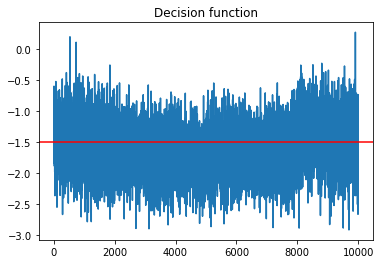

Decision function with threshold = -1.5
[[5749 3251]
 [ 278  722]]


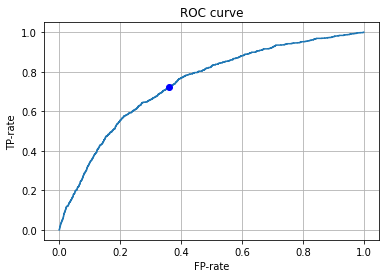

In [11]:
th = -1.5

y2d = sgd.decision_function(X2)
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.8957
Number of errors: 1043
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9000
           1       0.11      0.01      0.01      1000

    accuracy                           0.90     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.82      0.90      0.85     10000



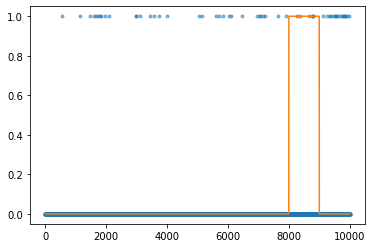

Prediction
[[8951   49]
 [ 994    6]]


In [12]:
sgd = SGDClassifier().fit(X1s, y1b)

y2e = sgd.predict(X2s)
print('Score:', sgd.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

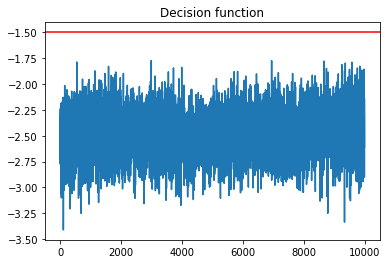

Decision function with threshold = -1.5
[[9000    0]
 [1000    0]]


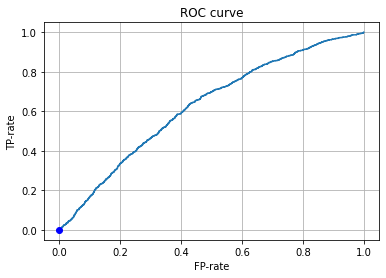

In [13]:
th = -1.5

y2d = sgd.decision_function(X2)
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


#### Compare normalization!

#### Why RandomForestClassifier!

## RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier


### Not normalized data

Score: 0.9122
Number of errors: 878
[[8943   57]
 [ 821  179]]


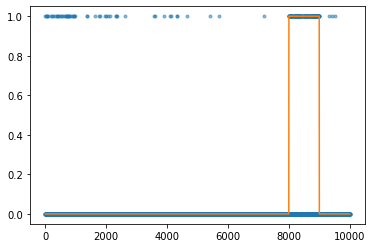

In [15]:
rfc = RandomForestClassifier().fit(X1, y1b)

y2e = rfc.predict(X2)
print('Score:', rfc.score(X2, y2b))

print("Number of errors:", np.sum(y2b != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)

cm = confusion_matrix(y2b, y2e)
print(cm)


### Normalized data

Score: 0.9122
Number of errors: 878
[[8947   53]
 [ 825  175]]


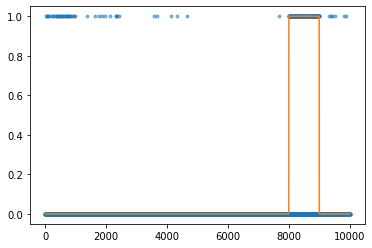

In [16]:
rfc = RandomForestClassifier().fit(X1s, y1b)

y2e = rfc.predict(X2s)
print('Score:', rfc.score(X2s, y2b))

print("Number of errors:", np.sum(y2b != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)

cm = confusion_matrix(y2b, y2e)
print(cm)


#### Compare normalization!

#### Compare classifiers!

# Multi-class classification

### Not normalized data

Score: 0.1483
Number of errors: 8517


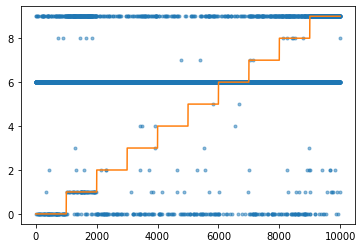

Confusion matrix, without normalization


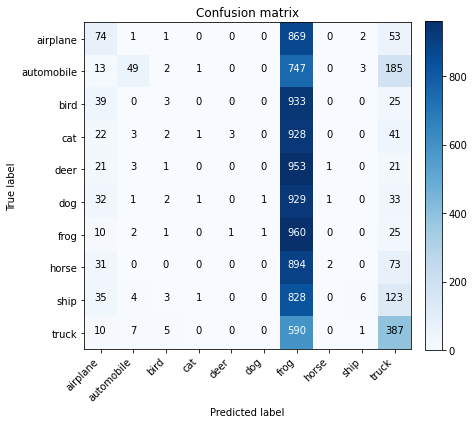

In [17]:
sgd = SGDClassifier().fit(X1, y1)

y2e = sgd.predict(X2)
print('Score:', sgd.score(X2, y2))

print("Number of errors:", np.sum(y2 != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

cm = confusion_matrix(y2, y2e)
# print(cm)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.2035
Number of errors: 7965
Confusion matrix, without normalization


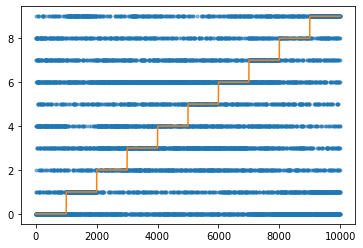

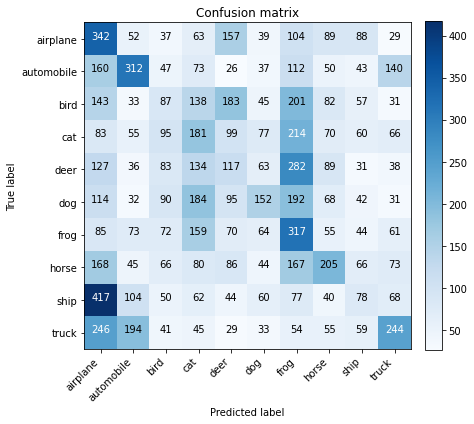

In [18]:
sgd = SGDClassifier().fit(X1s, y1)

y2e = sgd.predict(X2s)
print('Score:', sgd.score(X2s, y2))

print("Number of errors:", np.sum(y2 != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)

cm = confusion_matrix(y2, y2e)
# print(cm)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


## PCA

In [19]:
from sklearn.decomposition import PCA


### Not normalized data

Score: 0.1965
Number of errors: 8035


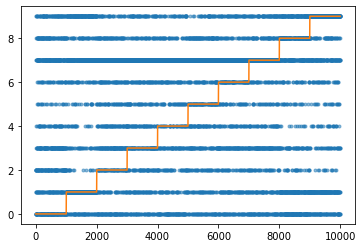

Confusion matrix, without normalization


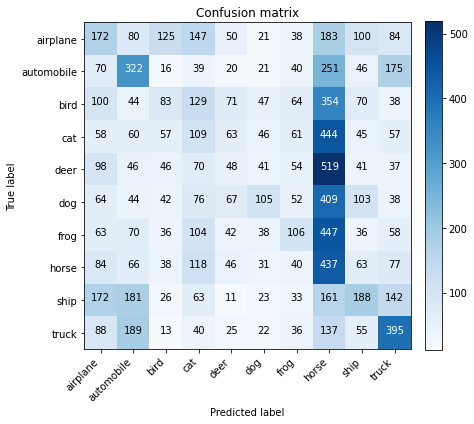

In [20]:
# Try different numbers of components
pca = PCA(n_components=None).fit(X1)
X1p = pca.transform(X1)
X2p = pca.transform(X2)

sgd = SGDClassifier().fit(X1p, y1)

y2e = sgd.predict(X2p)
print('Score:', sgd.score(X2p, y2))

print("Number of errors:", np.sum(y2 != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

cm = confusion_matrix(y2, y2e)
# print(cm)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.1924
Number of errors: 8076
Confusion matrix, without normalization


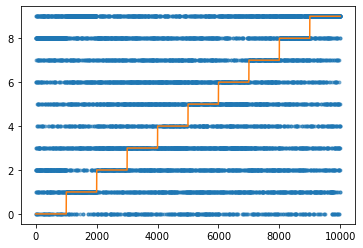

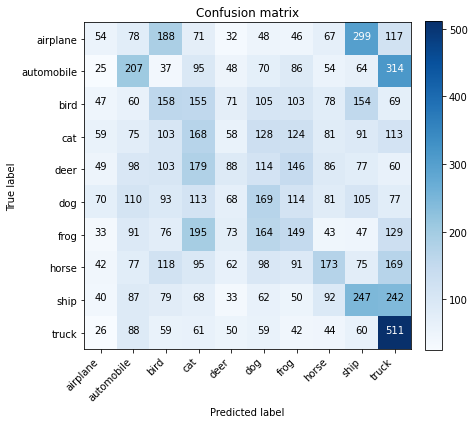

In [21]:
# Try different numbers of components
pca = PCA(n_components=None).fit(X1s)
X1sp = pca.transform(X1s)
X2sp = pca.transform(X2s)

sgd = SGDClassifier().fit(X1sp, y1)

y2e = sgd.predict(X2sp)
print('Score:', sgd.score(X2sp, y2))

print("Number of errors:", np.sum(y2 != y2e))
plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)

cm = confusion_matrix(y2, y2e)
# print(cm)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


Confusion matrix, without normalization


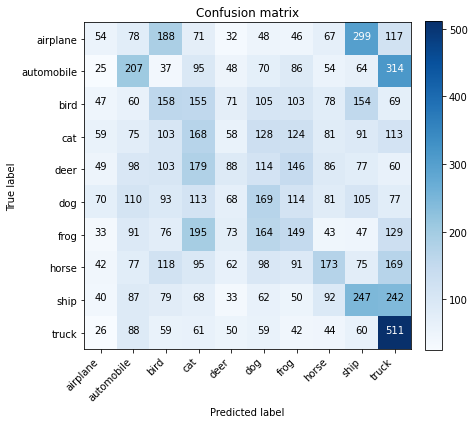

In [22]:
cm = confusion_matrix(y2, y2e)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


# Example preview

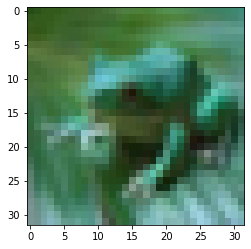

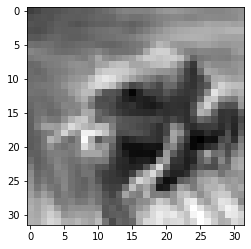

6


In [23]:
plot(Xtrain[0])
plot(XtrainG[0])
print(ytrain[0])
